# Bert Model

To improvement the performance, I implement the pre-trained model - Bert.

## 1. Load Data

In [1]:
# import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gensim
import tensorflow as tf
import keras
%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tf.__version__)
print("keras: " + keras.__version__)

2022-11-16 11:11:44.989756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 11:11:45.288186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 11:11:45.288198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 11:11:45.325782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 11:11:46.072223: W tensorflow/stream_executor/platform/de

gensim: 4.2.0
tensorflow: 2.10.0
keras: 2.10.0


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Since the pre-train language model requires lots of computation resource, I use GPU to run the program.

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.13.0+cu116
True


In [4]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# load the data
df = pd.read_pickle("part2_data/cleaned_tweets.pkl")

## 2. Preprocessing

In [7]:
df_train = df.loc[df.identification == 'train']
df_test = df.loc[df.identification == 'test']
df_train

,tweet_id,text,hashtags,emotion,identification,unigrams,remove_stopwords
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],anticipation,train,"[People, who, post, ``, add, me, on, #, Snapch...",People post `` add Snapchat '' must dehydrated...
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",sadness,train,"[@, brianklaas, As, we, see, ,, Trump, is, dan...",brianklaas see Trump dangerous freepress aroun...
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[],fear,train,"[Now, ISSA, is, stalking, Tasha, 😂😂😂, <, LH, >]",ISSA stalking Tasha 😂😂😂 LH
5,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]",joy,train,"[@, RISKshow, @, TheKevinAllison, Thx, for, th...",RISKshow TheKevinAllison Thx BEST TIME tonight...
6,0x2c91a8,Still waiting on those supplies Liscus. <LH>,[],anticipation,train,"[Still, waiting, on, those, supplies, Liscus, ...",Still waiting supplies Liscus LH
...,...,...,...,...,...,...,...
1867526,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,"[NoWonder, Happy]",joy,train,"[I, 'm, SO, HAPPY, !, !, !, #, NoWonder, the, ...",'m HAPPY NoWonder name show Happy HappySYFY SY...
1867527,0x38959e,In every circumtance I'd like to be thankful t...,[],joy,train,"[In, every, circumtance, I, 'd, like, to, be, ...",every circumtance 'd like thankful Almighty Je...
1867528,0x2cbca6,there's currently two girls walking around the...,[blessyou],joy,train,"[there, 's, currently, two, girls, walking, ar...",'s currently two girls walking around library ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",[],joy,train,"[Ah, ,, corporate, life, ,, where, you, can, d...",Ah corporate life date LH using relative anach...


emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64


Text(0.5, 0, 'category')

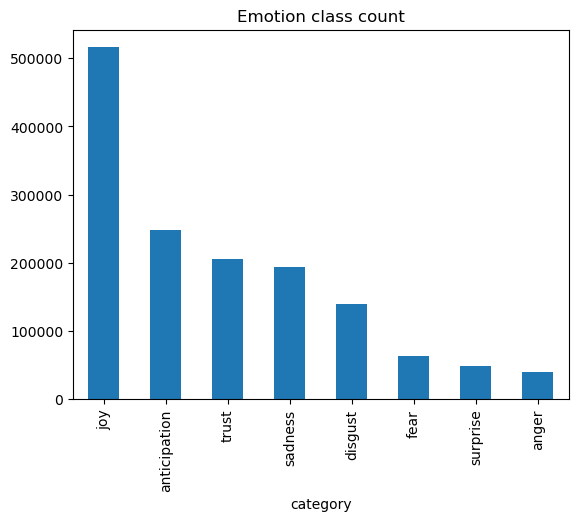

In [8]:
print(df_train.groupby(['emotion']).count()['text'])
df_train['emotion'].value_counts().plot(kind='bar')
plt.title('Emotion class count')
plt.xlabel("category")

Since Bert model is a more complex model, here I don't sample the data in order to get enough data to train.

In [9]:
# condition = df_train['emotion'] == 'anger'
# df_select = df_train[condition].sample(39867)
# condition = df_train['emotion'] == 'anticipation'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])
# condition = df_train['emotion'] == 'disgust'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])
# condition = df_train['emotion'] == 'fear'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])
# condition = df_train['emotion'] == 'joy'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])
# condition = df_train['emotion'] == 'sadness'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])
# condition = df_train['emotion'] == 'surprise'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])
# condition = df_train['emotion'] == 'trust'
# df_tmp = df_train[condition].sample(39867)
# df_select = pd.concat([df_select, df_tmp])

# df_train = df_select.reset_index(drop=True)
# print(df_train.groupby(['emotion']).count()['text'])

emotion
anger           39867
anticipation    39867
disgust         39867
fear            39867
joy             39867
sadness         39867
surprise        39867
trust           39867
Name: text, dtype: int64


## 3. Bert Model

### 3.1 Data Preprocessing

In [2]:
# import library
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from tabulate import tabulate
from tqdm import trange
import random

In [11]:
text = df_train.text.values
emotion = df_train.emotion.values

#### y

Transform the label into one hot encoding.

In [12]:
# deal with label into one hot
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(emotion)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

In [13]:
emotion = label_encode(label_encoder, emotion)

#### X

Tokenize the text as the preprocessing. Here I use the pre-trained Bert Tokenizer `bert-base-uncased`. Bert tokenizer follows the following process: 
1. Add special tokens such as `CLS`, `SER`. 
2. Add padding to make texts if the same length (`max_length`). 
3. Create the attention mask. 
For the second process, I have mentioned in BiLSTM model. For the third precess, since we do the padding, there may have some `0` behind the short text. To focus on the text, mask is added to filter out the `0` part of tokenized texts.

In [3]:
# token
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [15]:
# get the tokens and normalize them(padding, adding mask)
def preprocessing(input_text, tokenizer):
    token_text = tokenizer.encode_plus(input_text,
                                       add_special_tokens = True,
                                       max_length = 30,
                                       pad_to_max_length = True,
                                       return_attention_mask = True,
                                       return_tensors = 'pt')
    return token_text

In [16]:
token_id = []
attention_masks = []

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
emotion = torch.tensor(emotion)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [17]:
print('shape of emotion:', emotion.shape)
print('shape of token_id: ', token_id.shape)
print('shape of attention_mask: ', attention_masks.shape)

shape of emotion: torch.Size([318936, 8])
shape of token_id:  torch.Size([318936, 30])
shape of attention_mask:  torch.Size([318936, 30])


#### Split train and validation set

Here I use the index to do the splitting, then juxtapose the indexs to the `token_id` and `attention_mask`. After all preprocessing, I wrap them around a `DataLoader` object that is iterable.

In [18]:
# get splitting index
train_idx, val_idx = train_test_split(np.arange(len(emotion)), test_size = 0.2, shuffle = True, stratify = emotion)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], emotion[train_idx])
val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], emotion[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(train_set, sampler = RandomSampler(train_set), batch_size = 32)
validation_dataloader = DataLoader(val_set, sampler = SequentialSampler(val_set), batch_size = 32)

### 3.2 Build Model

I use the pre-train bert model `bert-base-uncased` as the original model and Adam as the optimizer.

In [19]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 8,
                                                      output_attentions = False, output_hidden_states = False,)

# set Adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, eps = 1e-08)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# set the device to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 3.3 Train the Model

#### Define the training statistics

In [22]:
def b_metrics(preds, labels):
    preds = np.argmax(preds, axis = 1).flatten()
    labels = np.argmax(labels, axis = 1).flatten()
    accuracy = accuracy_score(preds, labels)
    precision = precision_score(preds, labels, average='macro')
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    return accuracy, precision, recall, f1

#### Train!

In [23]:
epochs = 3

for e in trange(epochs, desc = 'Epoch'):
    
    '''========== Training =========='''
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        # send the data to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    '''========== Validation =========='''

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1 = []
    running_loss = 0.0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids,
                                token_type_ids = None,
                                attention_mask = b_input_mask)
        # record the logits
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_f1 = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update f1 only when (tn + fp) !=0; ignore nan
        if b_f1 != 'nan': val_f1.append(b_f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation f1: {:.4f}\n'.format(sum(val_f1)/len(val_f1)) if len(val_f1)>0 else '\t - Validation f1: NaN')
    file_path = './model/Bert_6_' + str(e)
    torch.save(model, file_path)

Epoch:   0%|                                                 | 0/3 [00:00<?, ?it/s]


	 - Train loss: 0.2695
	 - Validation Accuracy: 0.5215
	 - Validation Precision: 0.5156
	 - Validation Recall: 0.5282
	 - Validation f1: 0.4845



Epoch:  33%|█████████████▎                          | 1/3 [07:43<15:27, 463.98s/it]


	 - Train loss: 0.2291
	 - Validation Accuracy: 0.5355
	 - Validation Precision: 0.5285
	 - Validation Recall: 0.5317
	 - Validation f1: 0.4956



Epoch:  67%|██████████████████████████▋             | 2/3 [15:30<07:45, 465.39s/it]


	 - Train loss: 0.1949
	 - Validation Accuracy: 0.5333
	 - Validation Precision: 0.5258
	 - Validation Recall: 0.5290
	 - Validation f1: 0.4941



Epoch: 100%|████████████████████████████████████████| 3/3 [23:16<00:00, 465.59s/it]


In [24]:
# save the model
torch.save(model, './model/Bert_6')

### 3.4 Predict

In [25]:
# load the model
model = torch.load('./model/Bert_6')

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
test_text = df_test.text.values

In [28]:
# preprocess the testing data
test_token_id = []
test_attention_mask = []

for t in test_text:
    encoding_dict = preprocessing(t, tokenizer)
    test_token_id.append(encoding_dict['input_ids']) 
    test_attention_mask.append(encoding_dict['attention_mask'])
    
test_token_id = torch.cat(test_token_id, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

test_token_id = torch.unsqueeze(test_token_id, 1)
test_attention_mask = torch.unsqueeze(test_attention_mask, 1)

In [29]:
# Forward pass, calculate logit predictions
predict = []
with torch.no_grad():
    for t, m, i in zip(test_token_id, test_attention_mask, range(len(test_attention_mask))):
        output = model(t.to(device), token_type_ids = None, attention_mask = m.to(device))
        if i % 1000 == 0: print("finished:", i)
        predict.append(output.logits.cpu().numpy().flatten())

finished: 0
finished: 1000
finished: 2000
finished: 3000
finished: 4000
finished: 5000
finished: 6000
finished: 7000
finished: 8000
finished: 9000
finished: 10000
finished: 11000
finished: 12000
finished: 13000
finished: 14000
finished: 15000
finished: 16000
finished: 17000
finished: 18000
finished: 19000
finished: 20000
finished: 21000
finished: 22000
finished: 23000
finished: 24000
finished: 25000
finished: 26000
finished: 27000
finished: 28000
finished: 29000
finished: 30000
finished: 31000
finished: 32000
finished: 33000
finished: 34000
finished: 35000
finished: 36000
finished: 37000
finished: 38000
finished: 39000
finished: 40000
finished: 41000
finished: 42000
finished: 43000
finished: 44000
finished: 45000
finished: 46000
finished: 47000
finished: 48000
finished: 49000
finished: 50000
finished: 51000
finished: 52000
finished: 53000
finished: 54000
finished: 55000
finished: 56000
finished: 57000
finished: 58000
finished: 59000
finished: 60000
finished: 61000
finished: 62000
finis

In [30]:
y_pred = label_decode(label_encoder, predict)

In [33]:
tweet_id = df_test.tweet_id.tolist()

In [34]:
print(len(tweet_id), len(y_pred))

411972 411972


In [35]:
# save the prediction
df = pd.DataFrame(list(zip(tweet_id, y_pred)), columns =['id', 'emotion']) 
df.to_csv("./result/result_Bert_6.csv",index=False)